In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

## BALANCEO DE CLASES

In [2]:
path = './datasets/mitbih_train.csv'
df = pd.read_csv(path, header=None)
df.rename(columns={187:"label"}, inplace=True) #renombrar la columna de label

Distribución de clases:
 label
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Porcentaje por clase:
 label
0.0    82.77
4.0     7.35
2.0     6.61
1.0     2.54
3.0     0.73
Name: proportion, dtype: float64


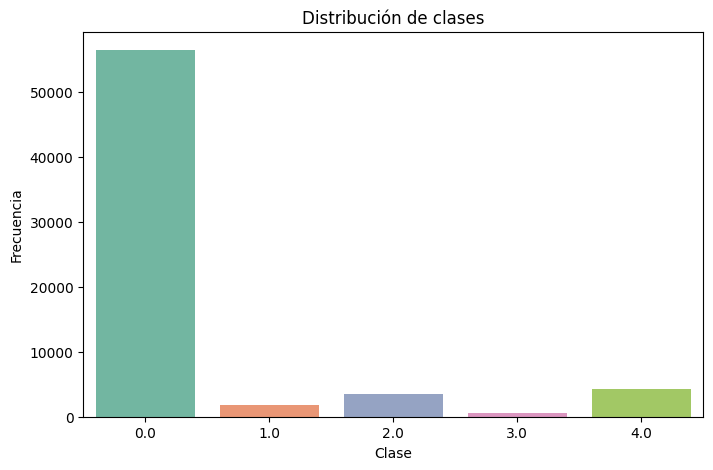

In [5]:
# Conteo de clases
class_counts = df['label'].value_counts()
print("Distribución de clases:\n", class_counts)

# Porcentaje de cada clase
class_percentages = df['label'].value_counts(normalize=True) * 100
print("\nPorcentaje por clase:\n", class_percentages.round(2))

# Visualización
plt.figure(figsize=(8, 5))
sns.countplot(x='label', hue='label', data=df, palette='Set2', legend=False)
plt.title('Distribución de clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()


Al revisar nuestro dataset de training, observamos que la proporción de labels de la clase 0 es considerablemente mayor, (el 82.7%) del total de los datos, que las otras clases. Inclusive hay una clase que representa menos del 1% (clase 3). Las otras 3 clases, contienen entre el 2% y 7% de los datos. Por lo anterior, se infiere que el dataset está desbalanceado.

### SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE es una técnica de sobremuestreo que genera nuevas instancias sintéticas de la clase minoritaria en lugar de simplemente replicar las existentes. Lo hace interpolando entre una muestra de la clase minoritaria y sus vecinos más cercanos en el espacio de características. Esto ayuda a crear un conjunto de datos más equilibrado sin sobreajustar el modelo a duplicados, como sucede con el sobremuestreo clásico, y resulta muy útil cuando el desequilibrio entre clases puede llevar al modelo a ignorar la clase minoritaria.

**Fundamento matemático**  
Para una muestra minoritaria $x_i$ y uno de sus $k$ vecinos más cercanos $x_{zi}$, se genera un punto sintético $x_{\text{synt}}$ al interpolar linealmente ambos vectores con un factor aleatorio $\lambda \in [0,1]$:

$$
x_{\text{synt}} = x_i + \lambda \cdot (x_{zi} - x_i).
$$


In [12]:
# Separar características (X) y etiqueta (y)
X = df.drop('label', axis=1)
y = df['label']

# Instanciar SMOTE
sm = SMOTE(random_state=42)

# Ajustar y transformar (resamplear) los datos
X_res, y_res = sm.fit_resample(X, y)

# Mostrar la forma de los datos antes y después
print("Tamaño de X original:", X.shape)
print("Distribución original de las clases:\n", y.value_counts())

print("\nTamaño de X tras SMOTE:", X_res.shape)
print("Distribución de las clases tras SMOTE:\n", y_res.value_counts())

Tamaño de X original: (87554, 187)
Distribución original de las clases:
 label
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Tamaño de X tras SMOTE: (362355, 187)
Distribución de las clases tras SMOTE:
 label
0.0    72471
1.0    72471
2.0    72471
3.0    72471
4.0    72471
Name: count, dtype: int64


### **Undersampling (submuestreo)** 

Es una técnica para manejar el desbalance de clases **reduciendo** el número de instancias de la clase mayoritaria. Con ello se busca equilibrar la proporción de ambas clases y evitar que el modelo ignore la clase minoritaria.

Supongamos que tenemos:

- Clase mayoritaria $ \mathcal{C}_{\text{maj}} $ con $ N $ instancias.
- Clase minoritaria $ \mathcal{C}_{\text{min}} $ con $ M $ instancias (donde $ M \ll N $).

La idea de **undersampling** es escoger aleatoriamente (o con algún criterio específico) un subconjunto

$$
\mathcal{C}_{\text{maj}}' \subseteq \mathcal{C}_{\text{maj}}
$$

con $ N' $ instancias, de modo que:

$$
N' \approx M 
\quad \text{o} \quad 
N' < N 
\quad (\text{con el fin de equilibrar}).
$$

El nuevo conjunto de datos se convierte en:

$$
\mathcal{D}' = \mathcal{C}_{\text{maj}}' \cup \mathcal{C}_{\text{min}}.
$$


In [14]:
# Separar características (X) y etiqueta (y)
X = df.drop('label', axis=1)
y = df['label']

# Instanciar UnderSampler
sm = RandomUnderSampler(random_state=42)

# Ajustar y transformar (resamplear) los datos
X_res, y_res = sm.fit_resample(X, y)

# Mostrar la forma de los datos antes y después
print("Tamaño de X original:", X.shape)
print("Distribución original de las clases:\n", y.value_counts())

print("\nTamaño de X tras SMOTE:", X_res.shape)
print("Distribución de las clases tras SMOTE:\n", y_res.value_counts())

Tamaño de X original: (87554, 187)
Distribución original de las clases:
 label
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Tamaño de X tras SMOTE: (3205, 187)
Distribución de las clases tras SMOTE:
 label
0.0    641
1.0    641
2.0    641
3.0    641
4.0    641
Name: count, dtype: int64



### ADASYN (Adaptive Synthetic Sampling)

ADASYN es una extensión de SMOTE que también crea muestras sintéticas, pero con un enfoque adaptativo: se enfoca en generar más datos sintéticos en las regiones donde la clase minoritaria es más difícil de aprender (es decir, donde hay mayor presencia de la clase mayoritaria). Al centrar la generación de datos en estas áreas críticas, el modelo es reforzado específicamente en los límites más complejos.

**Fundamento matemático**  

1. **Dificultad local** de la muestra minoritaria \\( x_i \\):
   \\[
   r_i = \\frac{\\text{(número de vecinos de la clase mayoritaria)}}{k},
   \\]
   donde \\( k \\) es la cantidad total de vecinos que se consideran alrededor de \\( x_i \\).

2. **Número de instancias sintéticas \\( G_i \\)** a generar para cada muestra \\( x_i \\):
   \\[
   G_i = \\frac{r_i}{\\sum_{j=1}^{n} r_j} \\cdot G,
   \\]
   donde \\( n \\) es el número de muestras minoritarias y \\( G \\) es la cantidad total de instancias sintéticas deseadas.

3. **Generación de nuevas muestras sintéticas**, igual que en SMOTE:
   \\[
   x_{\\text{synt}} = x_i + \\lambda \\cdot (x_{zi} - x_i),
   \\]
   usando un factor aleatorio \\( \\lambda \\in [0,1] \\).

De este modo, ADASYN concentra más muestras en las zonas donde la clase minoritaria es más complicada de aprender, a diferencia de SMOTE, que lo hace de forma más uniforme.

---




### class_weight='balanced' (Scikit-learn)

En lugar de modificar la distribución de datos, `class_weight='balanced'` asigna automáticamente un peso mayor a las clases menos representadas durante el entrenamiento de modelos como `LogisticRegression`, `RandomForestClassifier` o `SVC`. De esta forma, penaliza más los errores cometidos en las clases con menos muestras, forzando al modelo a prestarles mayor atención. Es una manera simple y efectiva de atenuar el sesgo sin alterar directamente los datos.

**Fundamento matemático**  
En Scikit-learn, el peso asignado a la clase \\( j \\) se calcula como:

\\[
w_j = \\frac{n}{k \\cdot n_j},
\\]

donde:
- \\( n \\) es el número total de muestras,
- \\( k \\) es el número total de clases,
- \\( n_j \\) es la cantidad de instancias de la clase \\( j \\).

Mientras más escasa sea una clase (menor \\( n_j \\)), mayor será su peso \\( w_j \\), lo que “protege” la clase minoritaria de ser ignorada.